In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, classification_report, confusion_matrix, precision_score, recall_score, brier_score_loss, mean_absolute_error, mean_squared_error, r2_score, roc_curve, auc
from sklearn.calibration import calibration_curve
from scipy.stats import pointbiserialr, pearsonr, chi2_contingency, shapiro, norm, linregress, spearmanr
from sklearn.utils import resample
from scipy import stats
from scipy.special import logit
import statsmodels.api as sm
from statsmodels.stats.proportion import proportion_confint

import warnings
warnings.filterwarnings('ignore')


In [2]:
training_data = pd.read_csv('/data/Training+Internal.csv')
train_df = training_data[training_data['database'] == 'v41_train'].copy()
internal_df = training_data[training_data['database'] == 'v41_test'].copy()
external_val_df = pd.read_csv('/data/external_dataset.csv')
internal_val_df = pd.read_csv('/data/internal_dataset.csv')


In [3]:
# ============================================
# demographic characteristics 
# ============================================

groups = external_val_df.groupby('group')
columns_to_analyzes = ['age', 'HAMD17', 'HAMA', 'SDS', 'PHQ', 'height', 'weight', 'BMI','whisper_all_score']
categorical_columns = ['nation', 'gender', 'marriage', 'smoking', 'drinking', 'family']
depressed_data = external_val_df[external_val_df['group'] == 'depressed']
healthy_data = external_val_df[external_val_df['group'] == 'healthy']
# Shapiro-Wilk test
for columns_to_analyze in columns_to_analyzes:
    feature_data = depressed_data[columns_to_analyze]  
    stat, p = shapiro(feature_data)
    alpha = 0.05
    print(f'{columns_to_analyze}:Statistics={stat:.3f}, p={p:.3f}')

for columns_to_analyze in columns_to_analyzes:
    feature_data = healthy_data[columns_to_analyze]
    stat, p = shapiro(feature_data)
    alpha = 0.05
    print(f'{columns_to_analyze}:Statistics={stat:.3f}, p={p:.3f}')

for group_name, group_data in groups:
    print(f"\n{group_name} Group Statistics:")
    for columns_to_analyze in columns_to_analyzes:
        column_data = group_data[columns_to_analyze].dropna()
        print(f"{columns_to_analyze}: mean={column_data.mean():.3f}, std={column_data.std():.3f}, median={column_data.median():.3f}, 25%-75%={np.percentile(column_data, [25, 75])}")

# t test
for columns_to_analyze in columns_to_analyzes:
    t_stat, p_val = stats.ttest_ind(groups.get_group('depressed')[columns_to_analyze].dropna(),
                                    groups.get_group('healthy')[columns_to_analyze].dropna(), equal_var=False)
    print(f"{columns_to_analyze} t-test: t={t_stat:.3f}, p={p_val:.3f}")

# Mann-Whitney U test
for columns_to_analyze in columns_to_analyzes:
    u_stat, p_val = stats.mannwhitneyu(groups.get_group('depressed')[columns_to_analyze].dropna(),
                                       groups.get_group('healthy')[columns_to_analyze].dropna())
    print(f"{columns_to_analyze} Mann-Whitney U test: U={u_stat:.3f}, p={p_val:.3f}")
results = pd.DataFrame(columns=['group', 'column', 'value', 'count'])
for group_name, group_data in groups:
    for column in categorical_columns:
        counts = group_data[column].value_counts().reset_index()
        counts.columns = ['value', 'count']
        counts['group'] = group_name
        counts['column'] = column
        results = pd.concat([results, counts], ignore_index=True)
print(results)

chi2_results = pd.DataFrame(columns=['column', 'chi2', 'p-value', 'dof', 'expected'])
for categorical_column in categorical_columns:
    contingency_table = pd.crosstab(external_val_df['group'], external_val_df[categorical_column])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi2_results = pd.concat([chi2_results, pd.DataFrame({
        'column': [categorical_column],
        'chi2': [chi2],
        'p-value': [p],
        'dof': [dof],
        'expected': [expected.tolist()]
    })], ignore_index=True)
print(chi2_results)


age:Statistics=0.911, p=0.000
HAMD17:Statistics=0.975, p=0.115
HAMA:Statistics=0.985, p=0.473
SDS:Statistics=0.969, p=0.047
PHQ:Statistics=0.977, p=0.168
height:Statistics=0.982, p=0.301
weight:Statistics=0.960, p=0.013
BMI:Statistics=0.983, p=0.359
whisper_all_score:Statistics=0.740, p=0.000
age:Statistics=0.691, p=0.000
HAMD17:Statistics=0.850, p=0.000
HAMA:Statistics=0.647, p=0.000
SDS:Statistics=0.950, p=0.004
PHQ:Statistics=0.886, p=0.000
height:Statistics=0.957, p=0.009
weight:Statistics=0.919, p=0.000
BMI:Statistics=0.942, p=0.001
whisper_all_score:Statistics=0.758, p=0.000

depressed Group Statistics:
age: mean=32.288, std=11.986, median=29.000, 25%-75%=[23.   37.75]
HAMD17: mean=19.925, std=4.622, median=20.000, 25%-75%=[16. 23.]
HAMA: mean=20.438, std=5.621, median=20.500, 25%-75%=[16.75 23.25]
SDS: mean=56.950, std=8.431, median=57.000, 25%-75%=[52. 63.]
PHQ: mean=17.462, std=4.888, median=17.500, 25%-75%=[13.75 22.  ]
height: mean=166.950, std=7.650, median=166.000, 25%-75%

In [4]:
# ============================================
# demographic baseline model
# ============================================

# Training set
X_train_demo = train_df[['age', 'gender']].values  
y_train = train_df['target_label'].values  
# Internal validation set
X_internal_demo = internal_val_df[['age', 'gender']].values
y_internal = internal_val_df['target_label'].values
# External validation set
X_external_demo = external_val_df[['age', 'gender']].values
y_external = external_val_df['target_label'].values
model_demo = LogisticRegression(
    random_state=42,      
    max_iter=1000,        
    solver='lbfgs'        
)
model_demo.fit(X_train_demo, y_train)

# Internal Validation
y_pred_internal_prob = model_demo.predict_proba(X_internal_demo)[:, 1]
y_pred_internal = model_demo.predict(X_internal_demo)
acc_internal = accuracy_score(y_internal, y_pred_internal)
auc_internal = roc_auc_score(y_internal, y_pred_internal_prob)
f1_internal = f1_score(y_internal, y_pred_internal)
print(f"Accuracy: {acc_internal:.3f} ({acc_internal*100:.1f}%)")
print(f"AUC: {auc_internal:.3f}")
print(f"F1-score: {f1_internal:.3f}")
print(classification_report(y_internal, y_pred_internal, 
                          target_names=['Healthy', 'MDD']))

# External Validation
y_pred_external_prob = model_demo.predict_proba(X_external_demo)[:, 1]
y_pred_external = model_demo.predict(X_external_demo)
acc_external = accuracy_score(y_external, y_pred_external)
auc_external = roc_auc_score(y_external, y_pred_external_prob)
f1_external = f1_score(y_external, y_pred_external)
print(f"Accuracy: {acc_external:.3f} ({acc_external*100:.1f}%)")
print(f"AUC: {auc_external:.3f}")
print(f"F1-score: {f1_external:.3f}")
print(classification_report(y_external, y_pred_external, 
                          target_names=['Healthy', 'MDD']))

def bootstrap_auc_ci(y_true, y_pred_prob, n_bootstraps=1000, seed=42):
    rng = np.random.RandomState(seed)
    auc_scores = []
    
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_true), len(y_true))
        auc = roc_auc_score(y_true[indices], y_pred_prob[indices])
        auc_scores.append(auc)

    auc_scores = np.array(auc_scores)
    ci_lower = np.percentile(auc_scores, 2.5)
    ci_upper = np.percentile(auc_scores, 97.5)   
    return ci_lower, ci_upper

# Internal validation的95% CI
ci_lower_int, ci_upper_int = bootstrap_auc_ci(y_internal, y_pred_internal_prob)
print(f"\nInternal Validation AUC: {auc_internal:.3f} (95% CI: {ci_lower_int:.3f}-{ci_upper_int:.3f})")

# External validation的95% CI
ci_lower_ext, ci_upper_ext = bootstrap_auc_ci(y_external, y_pred_external_prob)
print(f"External Validation AUC: {auc_external:.3f} (95% CI: {ci_lower_ext:.3f}-{ci_upper_ext:.3f})")
results = {
    'Model': 'Demographics-only',
    'Internal_Accuracy': f"{acc_internal:.3f}",
    'Internal_AUC': f"{auc_internal:.3f}",
    'Internal_AUC_CI': f"({ci_lower_int:.3f}-{ci_upper_int:.3f})",
    'Internal_F1': f"{f1_internal:.3f}",
    'External_Accuracy': f"{acc_external:.3f}",
    'External_AUC': f"{auc_external:.3f}",
    'External_AUC_CI': f"({ci_lower_ext:.3f}-{ci_upper_ext:.3f})",
    'External_F1': f"{f1_external:.3f}"
}
results_df = pd.DataFrame([results])

Accuracy: 0.631 (63.1%)
AUC: 0.647
F1-score: 0.602
              precision    recall  f1-score   support

     Healthy       0.63      0.68      0.66       171
         MDD       0.63      0.57      0.60       162

    accuracy                           0.63       333
   macro avg       0.63      0.63      0.63       333
weighted avg       0.63      0.63      0.63       333

Accuracy: 0.662 (66.2%)
AUC: 0.711
F1-score: 0.585
              precision    recall  f1-score   support

     Healthy       0.62      0.85      0.72        80
         MDD       0.76      0.47      0.58        80

    accuracy                           0.66       160
   macro avg       0.69      0.66      0.65       160
weighted avg       0.69      0.66      0.65       160


Internal Validation AUC: 0.647 (95% CI: 0.588-0.707)
External Validation AUC: 0.711 (95% CI: 0.625-0.785)


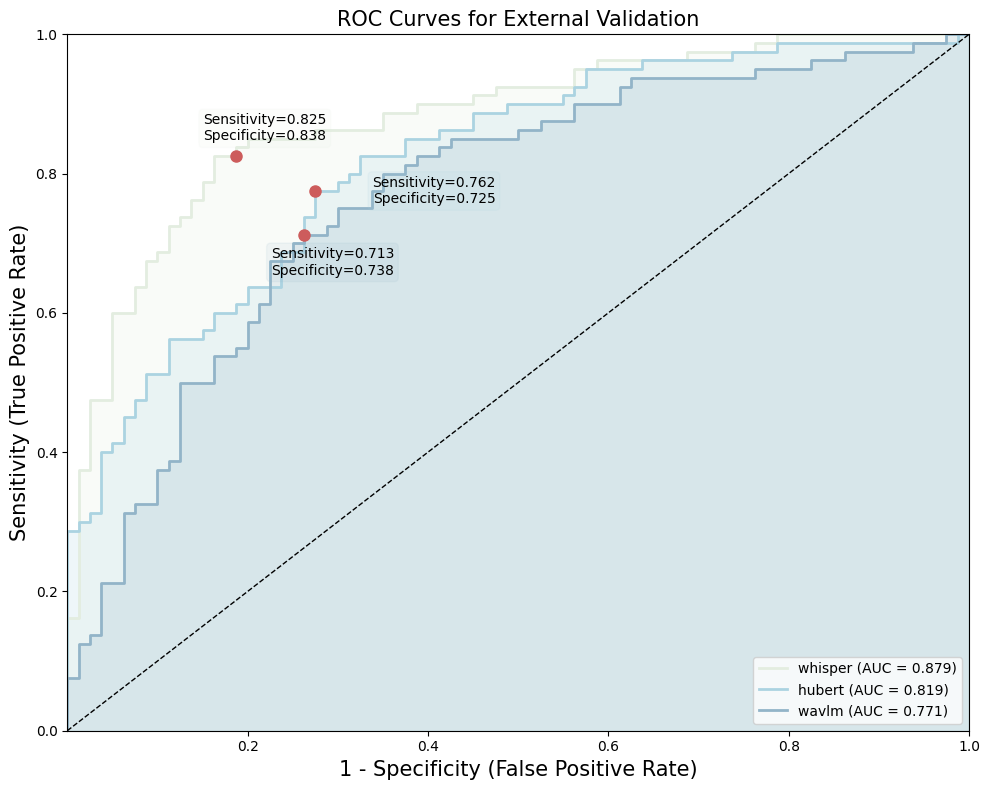

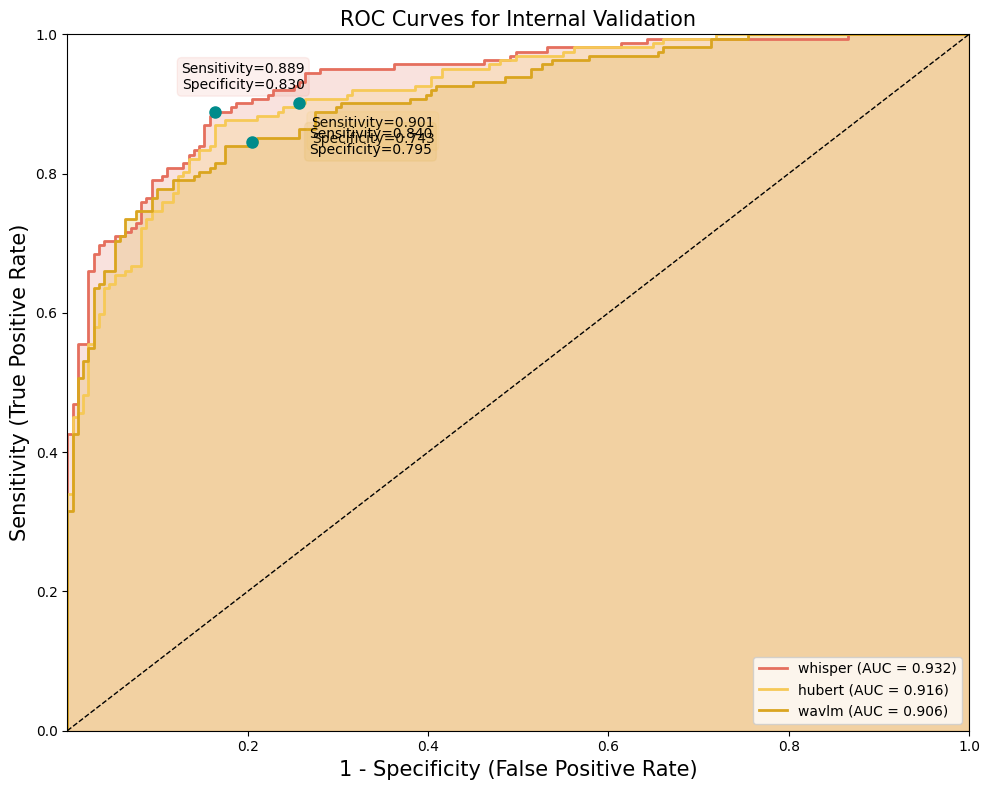

In [5]:

# ============================================
# compare models ROC (fig. 3c)
# ============================================

model_configs = {
    'whisper': 'whisper_all_score',
    'hubert': 'hubert_score',
    'wavlm': 'wavlm_score'
}

model_name_externals = ['whisper', 'hubert', 'wavlm'] 
model_name_internals = ['whisper', 'hubert', 'wavlm']

def bootstrap_auc(true_labels, predictive_values, n_bootstraps=2000, alpha=0.05):
    bootstrapped_scores = []
    rng = np.random.RandomState(seed=42)  # Control reproducibility

    for i in range(n_bootstraps):
        indices = rng.randint(0, len(true_labels), len(true_labels))
        if len(np.unique(true_labels[indices])) < 2:
            continue
        
        score = roc_auc_score(true_labels[indices], predictive_values[indices])
        bootstrapped_scores.append(score)

    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    
    lower = np.percentile(sorted_scores, 100*alpha/2)
    upper = np.percentile(sorted_scores, 100*(1-alpha/2))
    return lower, upper

def calculate_sensitivity_specificity(true_labels, predictive_values):
    tn, fp, fn, tp = confusion_matrix(true_labels, predictive_values).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return sensitivity, specificity

# ===== External Validation ROC Curves =====
colors_external = ['#E3EDE0', '#ABD3E1', '#92B4C8'] 
figure_size = (10, 8)
plt.figure(figsize=figure_size)

for i, model_name in enumerate(model_name_externals):
    score_column = model_configs[model_name]
    predictive_values = external_val_df [score_column].values
    true_labels = external_val_df ['target_label'].values

    valid_mask = ~(np.isnan(predictive_values) | np.isnan(true_labels))
    predictive_values = predictive_values[valid_mask]
    true_labels = true_labels[valid_mask]
    
    y_pred = (predictive_values >= 0.5).astype(int)
    sensitivity, specificity = calculate_sensitivity_specificity(true_labels, y_pred)
    fpr, tpr, thresholds = roc_curve(true_labels, predictive_values)
    roc_auc = auc(fpr, tpr)
    idx = np.argmin(np.abs(thresholds - 0.5))
    cut_off_fpr = fpr[idx]
    cut_off_tpr = tpr[idx]
    
    sens_lower, sens_upper = proportion_confint(count=sensitivity * np.sum(true_labels), 
                                                 nobs=np.sum(true_labels), 
                                                 alpha=0.05, method='wilson')
    spec_lower, spec_upper = proportion_confint(count=specificity * (len(true_labels) - np.sum(true_labels)), 
                                                 nobs=(len(true_labels) - np.sum(true_labels)), 
                                                 alpha=0.05, method='wilson')
    auc_lower, auc_upper = bootstrap_auc(true_labels, predictive_values)

    plt.plot(fpr, tpr, color=colors_external[i], lw=2, 
             label=f'{model_name} (AUC = {roc_auc:.3f})')    
    plt.fill_between(fpr, tpr, step='post', alpha=0.2, color=colors_external[i])
    
    x_offsets = [0.1, 0.2, 0.1]
    text_x = fpr[idx] + x_offsets[i]
    y_offsets = [0.04, 0, -0.04]
    text_y = tpr[idx] + y_offsets[i]
    
    plt.plot(cut_off_fpr, cut_off_tpr, marker='o', color='indianred', markersize=8)
    plt.annotate(f'Sensitivity={sensitivity:.3f}\nSpecificity={specificity:.3f}', 
                 xy=(fpr[idx], tpr[idx]), xytext=(text_x, text_y),
                 textcoords="data", ha='right', va='center',
                 bbox=dict(boxstyle="round", alpha=0.1, color=colors_external[i]))

plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=15)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize=15)
plt.title('ROC Curves for External Validation', fontsize=15)
plt.legend(loc="lower right")
plt.gca().set_xticks(plt.gca().get_xticks()[1:])
plt.tight_layout()
plt.show()

# ===== Internal Validation ROC Curves =====
colors_internal = ['#E56F5E', '#F6C957', 'goldenrod'] 
plt.figure(figsize=figure_size)

for i, model_name in enumerate(model_name_internals):
    score_column = model_configs[model_name]
    predictive_values = internal_val_df[score_column].values
    true_labels = internal_val_df['target_label'].values
    
    # 移除缺失值
    valid_mask = ~(np.isnan(predictive_values) | np.isnan(true_labels))
    predictive_values = predictive_values[valid_mask]
    true_labels = true_labels[valid_mask]
    
    y_pred = (predictive_values >= 0.5).astype(int)
    sensitivity, specificity = calculate_sensitivity_specificity(true_labels, y_pred)
    fpr, tpr, thresholds = roc_curve(true_labels, predictive_values)
    roc_auc = auc(fpr, tpr)
    idx = np.argmin(np.abs(thresholds - 0.5))
    
    sens_lower, sens_upper = proportion_confint(count=sensitivity * np.sum(true_labels), 
                                                 nobs=np.sum(true_labels), 
                                                 alpha=0.05, method='wilson')
    spec_lower, spec_upper = proportion_confint(count=specificity * (len(true_labels) - np.sum(true_labels)), 
                                                 nobs=(len(true_labels) - np.sum(true_labels)), 
                                                 alpha=0.05, method='wilson')
    auc_lower, auc_upper = bootstrap_auc(true_labels, predictive_values)
    
    plt.plot(fpr, tpr, color=colors_internal[i], lw=2, 
             label=f'{model_name} (AUC = {roc_auc:.3f})')    
    plt.fill_between(fpr, tpr, step='post', alpha=0.2, color=colors_internal[i])
    
    x_offsets = [0.1, 0.15, 0.2]
    text_x = fpr[idx] + x_offsets[i]
    y_offsets = [0.05, -0.04, 0]
    text_y = tpr[idx] + y_offsets[i]
    
    plt.plot(fpr[idx], tpr[idx], marker='o', color='darkcyan', markersize=8)
    plt.annotate(f'Sensitivity={sensitivity:.3f}\nSpecificity={specificity:.3f}', 
                 xy=(fpr[idx], tpr[idx]), xytext=(text_x, text_y),
                 textcoords="data", ha='right', va='center',
                 bbox=dict(boxstyle="round", alpha=0.1, color=colors_internal[i]))

plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=15)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize=15)
plt.title('ROC Curves for Internal Validation', fontsize=15)
plt.legend(loc="lower right")
plt.gca().set_xticks(plt.gca().get_xticks()[1:])
plt.tight_layout()
plt.show()

In [6]:
# ============================================
# Model Performance Metrics with 95% Confidence Intervals
# ============================================

def calc_auc_variance(aucs, n1, n2):
    V = np.zeros((2, 2))
    k = len(aucs)
    for i in range(k):
        auc = aucs[i]
        term1 = auc / (2.0 - auc)
        term2 = (2.0 * auc * auc) / (1.0 + auc)
        V[0, 0] += term1
        V[0, 1] += term2
        V[1, 1] += term1 * term2
    V[1, 0] = V[0, 1]
    V /= (k * n1 * n2)
    return V

def delong_roc_variance(ground_truth, predictions):
    order = np.argsort(-predictions)
    ground_truth = ground_truth[order]
    predictions = predictions[order]
    pos = ground_truth == 1
    n1 = np.sum(pos)
    n2 = np.sum(~pos)
    aucs = np.zeros((n1 + n2, 1))
    aucs[pos, 0] = np.cumsum(pos) / n1
    aucs[~pos, 0] = (np.cumsum(~pos) - np.arange(1, n2 + 1)) / n2
    aucs = aucs[np.argsort(order)]
    V = calc_auc_variance(aucs, n1, n2)
    return V

def delong_roc_test(ground_truth, predictions_one, predictions_two):
    auc_one = roc_auc_score(ground_truth, predictions_one)
    auc_two = roc_auc_score(ground_truth, predictions_two)
    aucs = np.zeros((2, len(predictions_one)))
    aucs[0, :] = predictions_one
    aucs[1, :] = predictions_two
    V = np.cov(aucs)
    S = np.dot(np.dot([1, -1], np.linalg.inv(V)), [1, -1])
    z = (auc_one - auc_two) / np.sqrt(S)
    p = scipy.stats.norm.sf(abs(z)) * 2
    return auc_one, auc_two, p

def compute_auc_with_ci(y_true, y_scores, alpha=0.95):
    auc_value = roc_auc_score(y_true, y_scores)
    n1 = sum(y_true)
    n2 = len(y_true) - n1
    q1 = auc_value / (2 - auc_value)
    q2 = 2 * auc_value ** 2 / (1 + auc_value)
    auc_se = np.sqrt((auc_value * (1 - auc_value) + (n1 - 1) * (q1 - auc_value ** 2) + (n2 - 1) * (q2 - auc_value ** 2)) / (n1 * n2))
    lower = auc_value - norm.ppf(1 - (1 - alpha) / 2) * auc_se
    upper = auc_value + norm.ppf(1 - (1 - alpha) / 2) * auc_se
    return auc_value, lower, upper

def compute_sensitivity_specificity_with_ci(y_true, y_pred, alpha=0.95):
    cm = confusion_matrix(y_true, y_pred)
    sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    se_sensitivity = np.sqrt((sensitivity * (1 - sensitivity)) / (cm[1, 0] + cm[1, 1]))
    se_specificity = np.sqrt((specificity * (1 - specificity)) / (cm[0, 0] + cm[0, 1]))
    lower_sensitivity = sensitivity - norm.ppf(1 - (1 - alpha) / 2) * se_sensitivity
    upper_sensitivity = sensitivity + norm.ppf(1 - (1 - alpha) / 2) * se_sensitivity
    lower_specificity = specificity - norm.ppf(1 - (1 - alpha) / 2) * se_specificity
    upper_specificity = specificity + norm.ppf(1 - (1 - alpha) / 2) * se_specificity
    return sensitivity, lower_sensitivity, upper_sensitivity, specificity, lower_specificity, upper_specificity

model_configs = [
    # External validation
    (external_val_df, 'all_ex', 'whisper_all_score'),
    (external_val_df, 'close_ex', 'whisper_close_score'),
    (external_val_df, 'open_ex', 'whisper_open_score'),
    (external_val_df, 'negative_ex', 'whisper_negative_score'),
    (external_val_df, 'neutral_ex', 'whisper_neutral_score'),
    (external_val_df, 'positive_ex', 'whisper_positive_score'),
    (external_val_df, 'hubert_ex', 'hubert_score'),
    (external_val_df, 'wavlm_ex', 'wavlm_score'),
    
    # Internal validation
    (internal_val_df, 'all_in', 'whisper_all_score'),
    (internal_val_df, 'close_in', 'whisper_close_score'),
    (internal_val_df, 'open_in', 'whisper_open_score'),
    (internal_val_df, 'negative_in', 'whisper_negative_score'),
    (internal_val_df, 'neutral_in', 'whisper_neutral_score'),
    (internal_val_df, 'positive_in', 'whisper_positive_score'),
    (internal_val_df, 'hubert_in', 'hubert_score'),
    (internal_val_df, 'wavlm_in', 'wavlm_score')
]

results = []

for df, model_name, score_column in model_configs:
    y_true = df['target_label'].values
    y_scores = df[score_column].values
    valid_mask = ~(np.isnan(y_true) | np.isnan(y_scores))
    y_true = y_true[valid_mask]
    y_scores = y_scores[valid_mask]
    auc_value, auc_lower, auc_upper = compute_auc_with_ci(y_true, y_scores)
    y_pred = (y_scores >= 0.5).astype(int)
    sensitivity, lower_sensitivity, upper_sensitivity, specificity, lower_specificity, upper_specificity = compute_sensitivity_specificity_with_ci(y_true, y_pred)
        
    results.append({
        'Model': model_name,
        'AUC': f"{auc_value:.3f}",
        'AUC_CI': f"({auc_lower:.3f}, {auc_upper:.3f})",
        'Sensitivity': f"{sensitivity:.3f}",
        'Sensitivity_CI': f"({lower_sensitivity:.3f}, {upper_sensitivity:.3f})",
        'Specificity': f"{specificity:.3f}",
        'Specificity_CI': f"({lower_specificity:.3f}, {upper_specificity:.3f})"
    })

results_df = pd.DataFrame(results)
print("\n" + "="*120)
print("Model Performance Metrics with 95% Confidence Intervals")
print("="*120)
print(results_df.to_string(index=False))



Model Performance Metrics with 95% Confidence Intervals
      Model   AUC         AUC_CI Sensitivity Sensitivity_CI Specificity Specificity_CI
     all_ex 0.879 (0.825, 0.934)       0.825 (0.742, 0.908)       0.838 (0.757, 0.918)
   close_ex 0.848 (0.787, 0.908)       0.700 (0.600, 0.800)       0.787 (0.698, 0.877)
    open_ex 0.831 (0.767, 0.894)       0.775 (0.683, 0.867)       0.738 (0.641, 0.834)
negative_ex 0.828 (0.763, 0.892)       0.775 (0.683, 0.867)       0.738 (0.641, 0.834)
 neutral_ex 0.837 (0.774, 0.900)       0.725 (0.627, 0.823)       0.762 (0.669, 0.856)
positive_ex 0.840 (0.777, 0.902)       0.700 (0.600, 0.800)       0.787 (0.698, 0.877)
  hubert_ex 0.819 (0.753, 0.884)       0.762 (0.669, 0.856)       0.725 (0.627, 0.823)
   wavlm_ex 0.771 (0.698, 0.844)       0.713 (0.613, 0.812)       0.738 (0.641, 0.834)
     all_in 0.932 (0.903, 0.961)       0.889 (0.840, 0.937)       0.830 (0.774, 0.887)
   close_in 0.911 (0.878, 0.944)       0.833 (0.776, 0.891)       0.795 (


Internal Duration Metrics:
   duration  Sensitivity  Specificity       Auc
0        20     0.740741     0.766082  0.869396
1        40     0.808642     0.754386  0.895567
2        80     0.851852     0.812865  0.923652
3       120     0.864198     0.847953  0.924807
4       240     0.800000     0.512397  0.674793

External Duration Metrics:
   duration  Sensitivity  Specificity       Auc
0        20     0.725000       0.6750  0.752812
1        40     0.662500       0.7125  0.762187
2        80     0.725000       0.7500  0.848438
3       120     0.750000       0.8125  0.834062
4       240     0.560606       0.0000       NaN


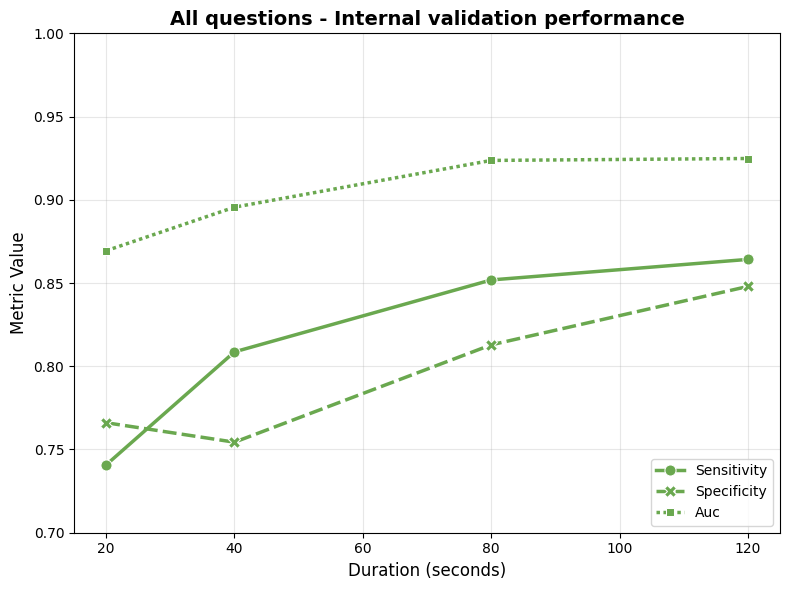

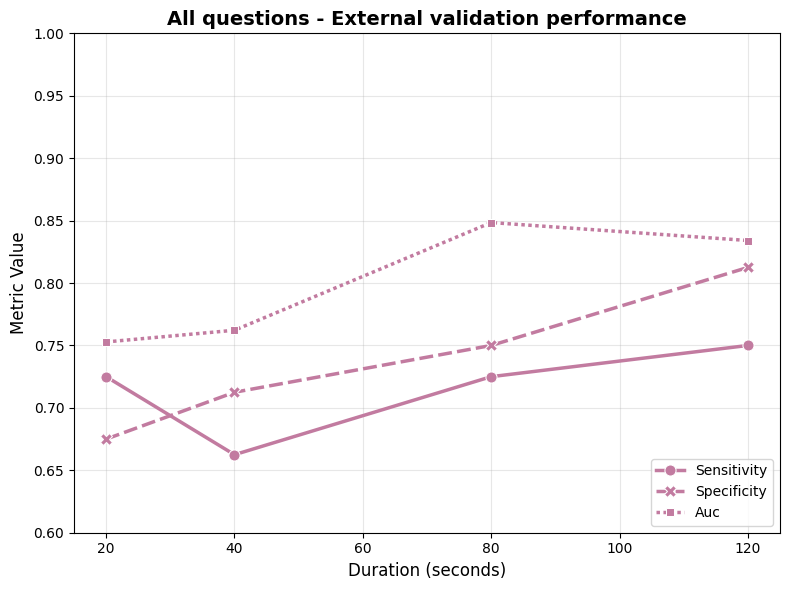

In [7]:
# ============================================
# compare duration (fig. 4a)
# ============================================

def extract_duration_metrics(df):

    durations = [20, 40, 80, 120, 240]
    results = []
    
    for duration in durations:
        score_col = f'duration{duration}_score'
        label_col = f'duration{duration}_label'

        y_true = df['target_label'].values
        y_score = df[score_col].values
        y_pred = df[label_col].values

        valid = ~(np.isnan(y_true) | np.isnan(y_score) | np.isnan(y_pred))
        y_true = y_true[valid]
        y_score = y_score[valid]
        y_pred = y_pred[valid].astype(int)
        
        if len(y_true) == 0:
            continue

        try:
            auc = roc_auc_score(y_true, y_score)
        except:
            auc = np.nan

        cm = confusion_matrix(y_true, y_pred)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        else:
            sensitivity = 0
            specificity = 0
        
        results.append({
            'duration': duration,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'Auc': auc
        })
    
    return pd.DataFrame(results)

df_internal = extract_duration_metrics(internal_val_df)
df_external = extract_duration_metrics(external_val_df)

print("\nInternal Duration Metrics:")
print(df_internal)
print("\nExternal Duration Metrics:")
print(df_external)

df_internal = df_internal[df_internal['duration'] != 240].copy()
df_external = df_external[df_external['duration'] != 240].copy()

# internal plot
df_melt = pd.melt(df_internal, 
                  id_vars=['duration'], 
                  value_vars=['Sensitivity', 'Specificity', 'Auc'], 
                  var_name='metric', 
                  value_name='value')

name = 'v41_test'
title = "All questions - Internal validation performance"
custom_palette = ['#6AA84F']

plt.figure(figsize=(8, 6))
sns.lineplot(x='duration', y='value', hue='metric', style='metric', 
             markers=True, data=df_melt, palette=custom_palette, 
             linewidth=2.5, markersize=8)
plt.legend(loc="lower right", fontsize=10)
plt.title(f"{title}", fontsize=14, fontweight='bold')
plt.xlabel('Duration (seconds)', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.ylim([0.7, 1.0])
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# external plot
df_melt_ = pd.melt(df_external, 
                   id_vars=['duration'], 
                   value_vars=['Sensitivity', 'Specificity', 'Auc'], 
                   var_name='metric', 
                   value_name='value')

name = 'rwe_test'
title = "All questions - External validation performance"
custom_palette = ['#C27BA0']

plt.figure(figsize=(8, 6))
sns.lineplot(x='duration', y='value', hue='metric', style='metric', 
             markers=True, data=df_melt_, palette=custom_palette,
             linewidth=2.5, markersize=8)
plt.legend(loc="lower right", fontsize=10)
plt.title(f"{title}", fontsize=14, fontweight='bold')
plt.xlabel('Duration (seconds)', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.ylim([0.6, 1.0])
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

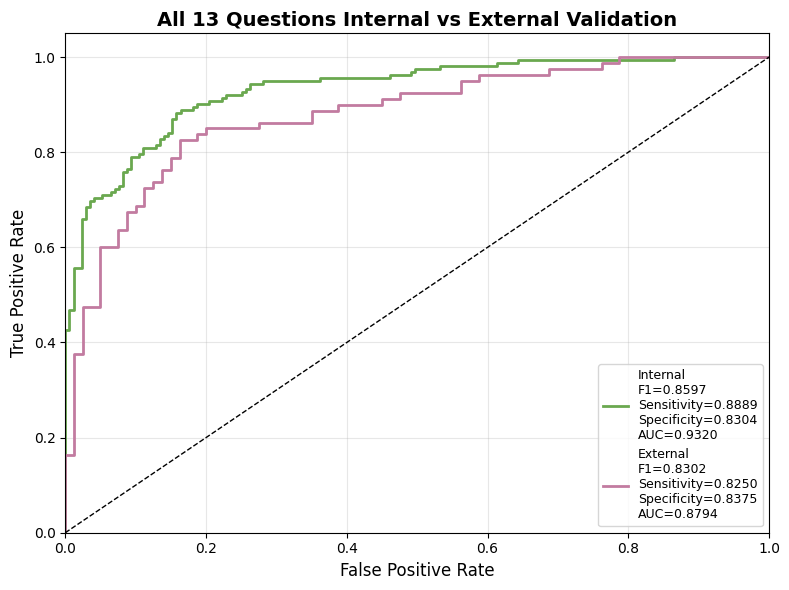

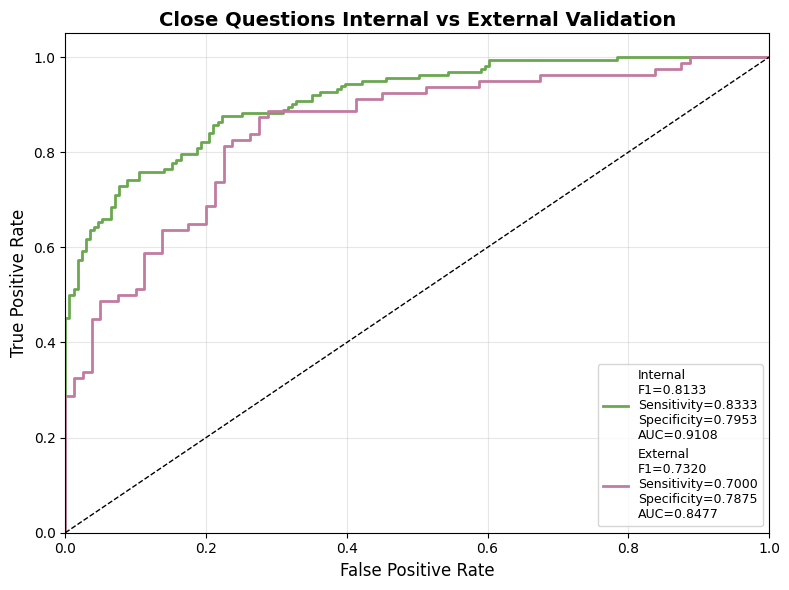

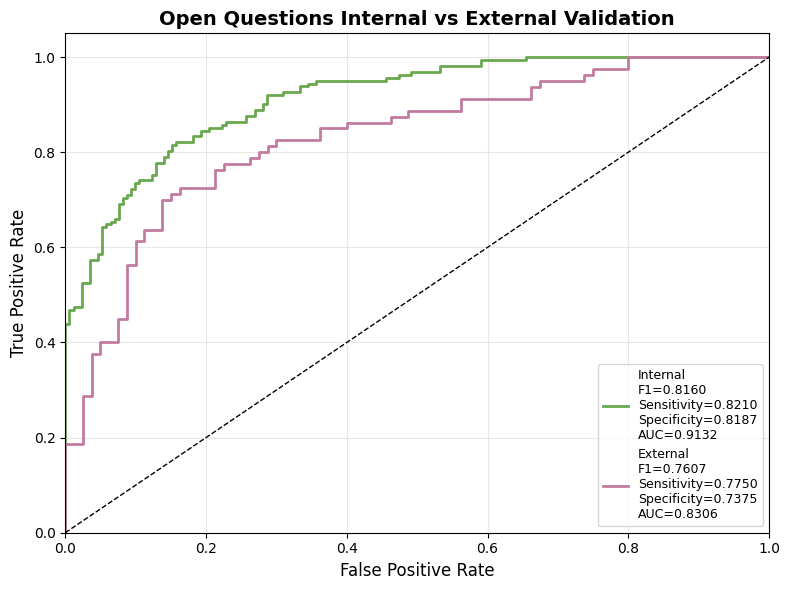

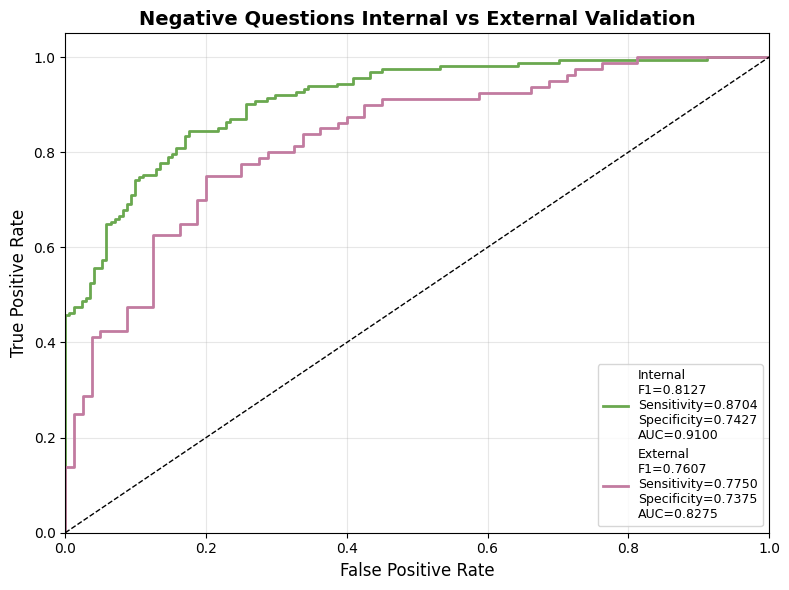

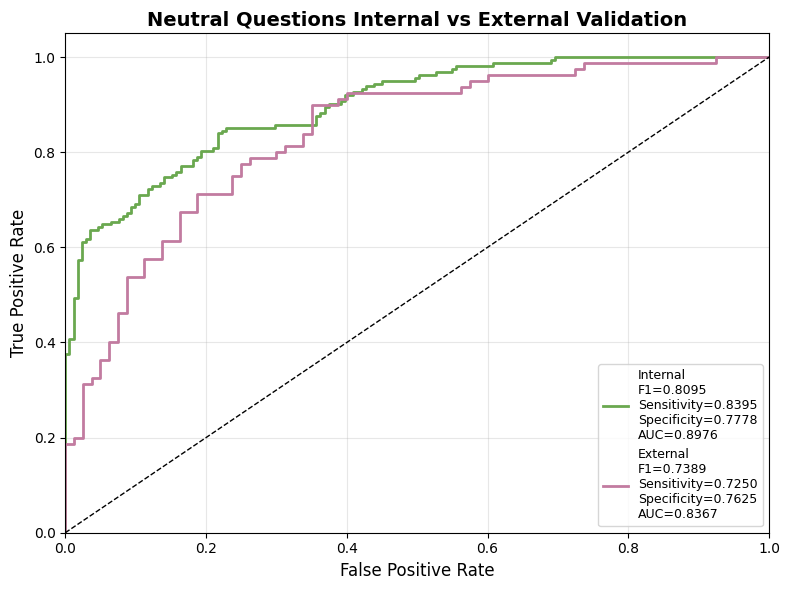

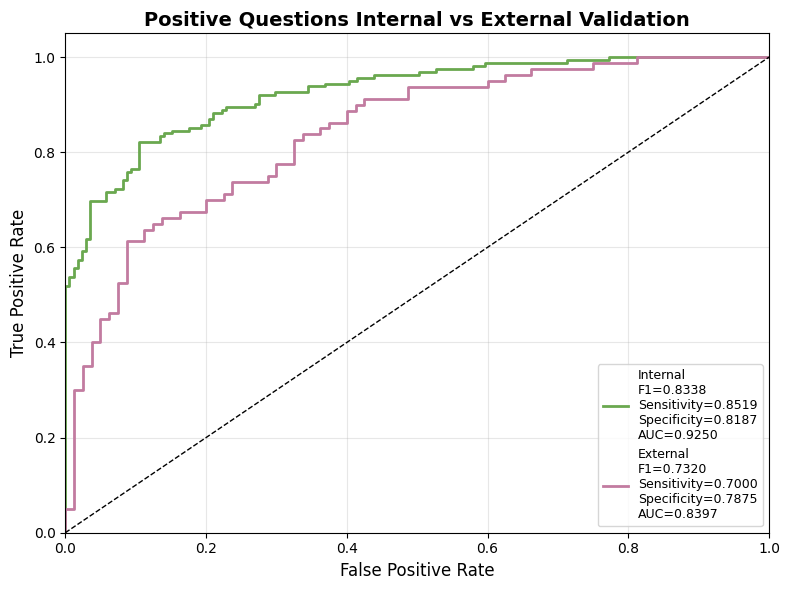

In [8]:

# ============================================
# compare dimension ROC (fig. 4b & c)
# ============================================

def plot_roc_comparison(internal_val_df, external_val_df, score_column, title_suffix):

    y_true_in = internal_val_df['target_label'].values
    y_score_in = internal_val_df[score_column].values
    valid_in = ~(np.isnan(y_true_in) | np.isnan(y_score_in))
    y_true_in = y_true_in[valid_in]
    y_score_in = y_score_in[valid_in]
    
    y_true_ex = external_val_df['target_label'].values
    y_score_ex = external_val_df[score_column].values
    valid_ex = ~(np.isnan(y_true_ex) | np.isnan(y_score_ex))
    y_true_ex = y_true_ex[valid_ex]
    y_score_ex = y_score_ex[valid_ex]
    
    y_pred_in = (y_score_in >= 0.5).astype(int)
    f1_in = f1_score(y_true_in, y_pred_in)
    cm_in = confusion_matrix(y_true_in, y_pred_in)
    sensitivity_in = cm_in[1, 1] / (cm_in[1, 0] + cm_in[1, 1])
    specificity_in = cm_in[0, 0] / (cm_in[0, 0] + cm_in[0, 1])
    auc_in = roc_auc_score(y_true_in, y_score_in)
    fpr_in, tpr_in, _ = roc_curve(y_true_in, y_score_in)
    
    y_pred_ex = (y_score_ex >= 0.5).astype(int)
    f1_ex = f1_score(y_true_ex, y_pred_ex)
    cm_ex = confusion_matrix(y_true_ex, y_pred_ex)
    sensitivity_ex = cm_ex[1, 1] / (cm_ex[1, 0] + cm_ex[1, 1])
    specificity_ex = cm_ex[0, 0] / (cm_ex[0, 0] + cm_ex[0, 1])
    auc_ex = roc_auc_score(y_true_ex, y_score_ex)
    fpr_ex, tpr_ex, _ = roc_curve(y_true_ex, y_score_ex)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_in, tpr_in, color='#6AA84F', lw=2, 
             label=f'Internal\nF1={f1_in:.4f}\nSensitivity={sensitivity_in:.4f}\nSpecificity={specificity_in:.4f}\nAUC={auc_in:.4f}')
    
    plt.plot(fpr_ex, tpr_ex, color='#C27BA0', lw=2, 
             label=f'External\nF1={f1_ex:.4f}\nSensitivity={sensitivity_ex:.4f}\nSpecificity={specificity_ex:.4f}\nAUC={auc_ex:.4f}')
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'{title_suffix} Internal vs External Validation', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=9)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# 1. All 13 questions
plot_roc_comparison(internal_val_df, external_val_df, 'whisper_all_score', 'All 13 Questions')
# 2. Close questions
plot_roc_comparison(internal_val_df, external_val_df, 'whisper_close_score', 'Close Questions')
# 3. Open questions
plot_roc_comparison(internal_val_df, external_val_df, 'whisper_open_score', 'Open Questions')
# 4. Negative questions
plot_roc_comparison(internal_val_df, external_val_df, 'whisper_negative_score', 'Negative Questions')
# 5. Neutral questions
plot_roc_comparison(internal_val_df, external_val_df, 'whisper_neutral_score', 'Neutral Questions')
# 6. Positive questions
plot_roc_comparison(internal_val_df, external_val_df, 'whisper_positive_score', 'Positive Questions')


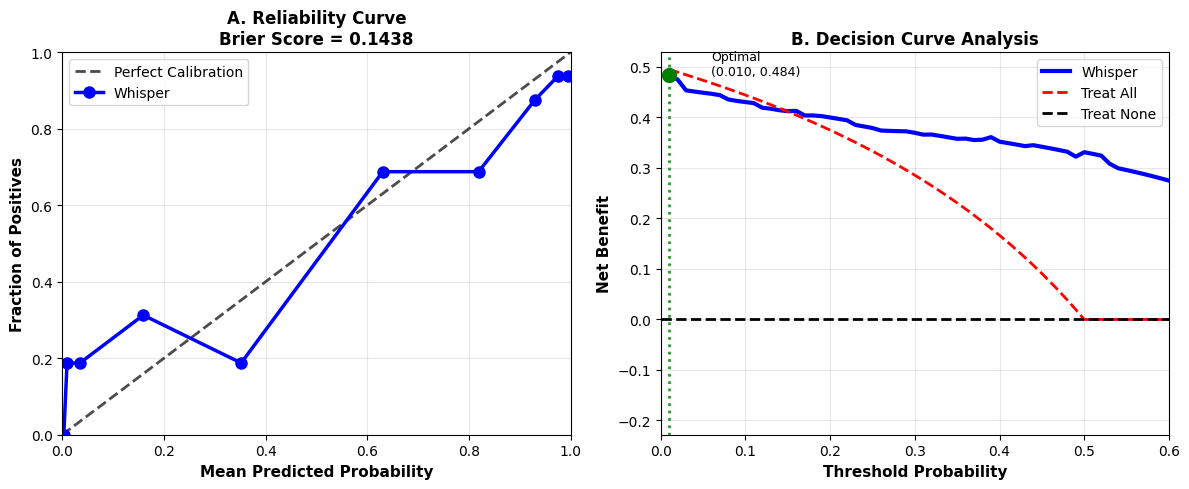

In [9]:

# ============================================
# Calibration and Decision Analysis
# ============================================

y_true = external_val_df['target_label']
y_prob = external_val_df['whisper_all_score']

def generate_supplementary_figure(y_true, y_prob, model_name="Whisper"):

    brier_score = brier_score_loss(y_true, y_prob)
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, y_prob, n_bins=10, strategy='quantile'
    )

    thresholds = np.arange(0.01, 0.99, 0.01)
    n_total = len(y_true)
    prevalence = np.mean(y_true)
    
    net_benefits_model = []
    net_benefits_all = []
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        
        weight = threshold / (1 - threshold)
        nb_model = (tp / n_total) - (fp / n_total) * weight
        nb_all = prevalence - (1 - prevalence) * weight
        
        net_benefits_model.append(nb_model)
        net_benefits_all.append(max(nb_all, 0))

    optimal_idx = np.argmax(net_benefits_model)
    optimal_threshold = thresholds[optimal_idx]
    optimal_benefit = net_benefits_model[optimal_idx]

    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 5))
    
    # A. Reliability Curve
    ax1.plot([0, 1], [0, 1], 'k--', alpha=0.7, linewidth=2, label='Perfect Calibration')
    ax1.plot(mean_predicted_value, fraction_of_positives, 'bo-', 
             markersize=8, linewidth=2.5, label=model_name)
    ax1.set_xlabel('Mean Predicted Probability', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Fraction of Positives', fontsize=11, fontweight='bold')
    ax1.set_title(f'A. Reliability Curve\nBrier Score = {brier_score:.4f}', 
                  fontsize=12, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    
    # B. Decision Curve
    ax2.plot(thresholds, net_benefits_model, 'b-', linewidth=3, label=model_name)
    ax2.plot(thresholds, net_benefits_all, 'r--', linewidth=2, label='Treat All')
    ax2.axhline(y=0, color='k', linestyle='--', linewidth=2, label='Treat None')
    ax2.axvline(x=optimal_threshold, color='green', linestyle=':', alpha=0.8, 
                linewidth=2)
    ax2.scatter([optimal_threshold], [optimal_benefit], color='green', 
                s=100, zorder=5)
    ax2.text(optimal_threshold + 0.05, optimal_benefit, 
             f'Optimal\n({optimal_threshold:.3f}, {optimal_benefit:.3f})',
             fontsize=9, ha='left')
    ax2.set_xlabel('Threshold Probability', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Net Benefit', fontsize=11, fontweight='bold')
    ax2.set_title('B. Decision Curve Analysis', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim([0, 0.6])
    plt.tight_layout()
    plt.show()
    
    return {
        'brier_score': brier_score,
        'optimal_threshold': optimal_threshold,
        'optimal_benefit': optimal_benefit
    }

results = generate_supplementary_figure(y_true, y_prob)




 Gender Difference (Chi-square test):
   • χ² = 0.000, p = 1.0000

 Age Group Difference (Kruskal-Wallis test):
   • H = 3.862, p = 0.1450


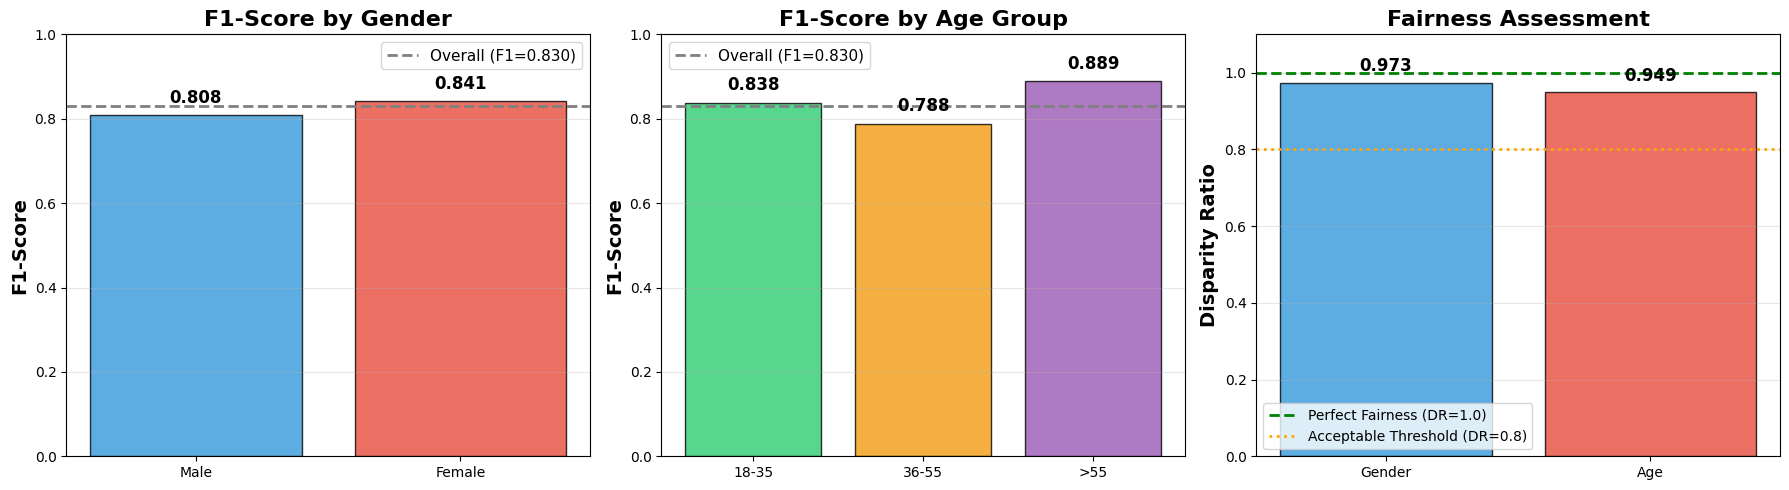

Subgroup Fairness Analysis

Subgroup        |     N |  N_Dep |     AUC |      F1 |     Acc |     Sen |     Spe
Overall         |   160 |     80 |   0.879 |   0.830 |   0.831 |   0.825 |   0.838
Male            |    65 |     27 |   0.887 |   0.808 |   0.846 |   0.778 |   0.895
Female          |    95 |     53 |   0.870 |   0.841 |   0.821 |   0.849 |   0.786
Age 18-35       |   129 |     56 |   0.909 |   0.838 |   0.853 |   0.875 |   0.836
Age 36-55       |    25 |     19 |   0.737 |   0.788 |   0.720 |   0.684 |   0.833
Age >55         |     6 |      5 |   0.800 |   0.889 |   0.833 |   0.800 |   1.000
Disparity Ratio | Gender DR=0.973, Age DR=0.949


In [10]:
# ============================================
# Subgroup Fairness Analysis
# ============================================

external_val_df['gender_label'] = external_val_df['gender'].map({1: 'Male', 2: 'Female'})

def create_age_groups(age):
    if age < 36:
        return '18-35'
    elif age < 56:
        return '36-55'
    else:
        return '>55'
external_val_df['age_group'] = external_val_df['age'].apply(create_age_groups)
for age_group in ['18-35', '36-55', '>55']:
    count = sum(external_val_df['age_group'] == age_group)

def calculate_metrics(y_true, y_pred, y_score):

    if len(y_true) == 0:
        return None
    try:
        auc = roc_auc_score(y_true, y_score)
    except:
        auc = np.nan
    
    f1 = f1_score(y_true, y_pred, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)

    cm = confusion_matrix(y_true, y_pred)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    else:
        tn, fp, fn, tp = 0, 0, 0, 0
    
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    return {
        'N': len(y_true),
        'N_Positive': sum(y_true),
        'N_Negative': len(y_true) - sum(y_true),
        'AUC': auc,
        'F1': f1,
        'Accuracy': accuracy,
        'Precision': precision,
        'Sensitivity': recall,
        'Specificity': specificity,
        'TP': tp,
        'FP': fp,
        'TN': tn,
        'FN': fn
    }

results = []
overall_metrics = calculate_metrics(external_val_df['target_label'], external_val_df['whisper_all_label'],  external_val_df['whisper_all_score'])
overall_metrics['Subgroup'] = 'Overall'
overall_metrics['Type'] = 'Overall'
results.append(overall_metrics)

# Gender Subgroups
for gender in ['Male', 'Female']:
    subset = external_val_df[external_val_df['gender_label'] == gender]
    if len(subset) > 5:
        metrics = calculate_metrics(subset['target_label'], subset['whisper_all_label'], subset['whisper_all_score'])
        if metrics is not None:
            metrics['Subgroup'] = gender
            metrics['Type'] = 'Gender'
            results.append(metrics)
    else:
        print(f"   ⚠ {gender}: Only {len(subset)} samples, skipping")

# Age Subgroups
for age_group in ['18-35', '36-55', '>55']:
    subset = external_val_df[external_val_df['age_group'] == age_group]
    if len(subset) > 5:
        metrics = calculate_metrics(subset['target_label'], subset['whisper_all_label'], subset['whisper_all_score'])
        if metrics is not None:
            metrics['Subgroup'] = f'Age {age_group}'
            metrics['Type'] = 'Age'
            results.append(metrics)
    else:
        print(f"   ⚠ {age_group}: Only {len(subset)} samples, skipping")

results_df = pd.DataFrame(results)
overall_f1 = results_df[results_df['Subgroup'] == 'Overall']['F1'].values[0]

# Gender DR
gender_f1_scores = results_df[results_df['Type'] == 'Gender']['F1'].values
if len(gender_f1_scores) > 0:
    gender_dr = min(gender_f1_scores) / overall_f1 if overall_f1 > 0 else np.nan
else:
    gender_dr = np.nan

# Age DR
age_f1_scores = results_df[results_df['Type'] == 'Age']['F1'].values
if len(age_f1_scores) > 0:
    age_dr = min(age_f1_scores) / overall_f1 if overall_f1 > 0 else np.nan
    for age_group in ['18-35', '36-55', '>55']:
        age_row = results_df[results_df['Subgroup'] == f'Age {age_group}']
else:
    age_dr = np.nan

results_df['Gender_DR'] = gender_dr
results_df['Age_DR'] = age_dr

# Gender comparison (Chi-square test)
male_data = external_val_df[external_val_df['gender_label'] == 'Male']
female_data = external_val_df[external_val_df['gender_label'] == 'Female']
if len(male_data) > 0 and len(female_data) > 0:
    male_cm = confusion_matrix(male_data['target_label'], male_data['whisper_all_label'])
    female_cm = confusion_matrix(female_data['target_label'], female_data['whisper_all_label'])
    
    if male_cm.shape == (2,2) and female_cm.shape == (2,2):
        male_tp, male_fp = male_cm[1,1], male_cm[0,1]
        female_tp, female_fp = female_cm[1,1], female_cm[0,1]
        
        contingency_table = np.array([
            [male_tp, male_fp],
            [female_tp, female_fp]
        ])
        
        chi2, p_value = stats.chi2_contingency(contingency_table)[:2]
        print(f"\n Gender Difference (Chi-square test):")
        print(f"   • χ² = {chi2:.3f}, p = {p_value:.4f}")

# Age group comparison (Kruskal-Wallis test)
age_groups_data = []
age_group_names = []
for age_group in ['18-35', '36-55', '>55']:
    subset = external_val_df[external_val_df['age_group'] == age_group]
    if len(subset) > 0:
        age_groups_data.append(subset['whisper_all_score'].values)
        age_group_names.append(f"{age_group} (N={len(subset)})")
if len(age_groups_data) >= 2:
    h_stat, p_value = stats.kruskal(*age_groups_data)
    print(f"\n Age Group Difference (Kruskal-Wallis test):")
    print(f"   • H = {h_stat:.3f}, p = {p_value:.4f}")
    
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
# Plot 1: F1-Score by Gender
gender_data = results_df[results_df['Type'] == 'Gender']
if len(gender_data) > 0:
    ax1 = axes[0]
    x_labels = gender_data['Subgroup'].values
    f1_scores = gender_data['F1'].values
    
    bars = ax1.bar(x_labels, f1_scores, color=['#3498db', '#e74c3c'], alpha=0.8, edgecolor='black')
    ax1.axhline(y=overall_f1, color='gray', linestyle='--', linewidth=2, label=f'Overall (F1={overall_f1:.3f})')
    ax1.set_ylabel('F1-Score', fontsize=14, fontweight='bold')
    ax1.set_title('F1-Score by Gender', fontsize=16, fontweight='bold')
    ax1.set_ylim([0, 1.0])
    ax1.legend(fontsize=11)
    ax1.grid(axis='y', alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Plot 2: F1-Score by Age Group
age_data = results_df[results_df['Type'] == 'Age']
if len(age_data) > 0:
    ax2 = axes[1]
    x_labels = [s.replace('Age ', '') for s in age_data['Subgroup'].values]
    f1_scores = age_data['F1'].values
    
    bars = ax2.bar(x_labels, f1_scores, color=['#2ecc71', '#f39c12', '#9b59b6'], alpha=0.8, edgecolor='black')
    ax2.axhline(y=overall_f1, color='gray', linestyle='--', linewidth=2, label=f'Overall (F1={overall_f1:.3f})')
    ax2.set_ylabel('F1-Score', fontsize=14, fontweight='bold')
    ax2.set_title('F1-Score by Age Group', fontsize=16, fontweight='bold')
    ax2.set_ylim([0, 1.0])
    ax2.legend(fontsize=11)
    ax2.grid(axis='y', alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Plot 3: Disparity Ratio
ax3 = axes[2]
dr_data = []
dr_labels = []
dr_colors = []

if not np.isnan(gender_dr):
    dr_data.append(gender_dr)
    dr_labels.append('Gender')
    dr_colors.append('#3498db')

if not np.isnan(age_dr):
    dr_data.append(age_dr)
    dr_labels.append('Age')
    dr_colors.append('#e74c3c')

if len(dr_data) > 0:
    bars = ax3.bar(dr_labels, dr_data, color=dr_colors, alpha=0.8, edgecolor='black')
    ax3.axhline(y=1.0, color='green', linestyle='--', linewidth=2, label='Perfect Fairness (DR=1.0)')
    ax3.axhline(y=0.8, color='orange', linestyle=':', linewidth=2, label='Acceptable Threshold (DR=0.8)')
    ax3.set_ylabel('Disparity Ratio', fontsize=14, fontweight='bold')
    ax3.set_title('Fairness Assessment', fontsize=16, fontweight='bold')
    ax3.set_ylim([0, 1.1])
    ax3.legend(fontsize=10)
    ax3.grid(axis='y', alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


print("Subgroup Fairness Analysis")
print(f"\n{'Subgroup':<15} | {'N':>5} | {'N_Dep':>6} | {'AUC':>7} | {'F1':>7} | {'Acc':>7} | {'Sen':>7} | {'Spe':>7}")

subgroups_order = ['Overall', 'Male', 'Female', 'Age 18-35', 'Age 36-55', 'Age >55']
for subgroup in subgroups_order:
    row = results_df[results_df['Subgroup'] == subgroup]
    if len(row) > 0:
        r = row.iloc[0]
        print(f"{r['Subgroup']:<15} | {int(r['N']):>5} | {int(r['N_Positive']):>6} | {r['AUC']:>7.3f} | {r['F1']:>7.3f} | {r['Accuracy']:>7.3f} | {r['Sensitivity']:>7.3f} | {r['Specificity']:>7.3f}")
dr_text = ""
if not np.isnan(gender_dr):
    dr_text += f"Gender DR={gender_dr:.3f}"
if not np.isnan(age_dr):
    if dr_text:
        dr_text += ", "
    dr_text += f"Age DR={age_dr:.3f}"
print(f"{'Disparity Ratio':<15} | {dr_text}")
paper_table = []
for subgroup in subgroups_order:
    row_data = results_df[results_df['Subgroup'] == subgroup]
    if len(row_data) > 0:
        r = row_data.iloc[0]
        paper_table.append({
            'Subgroup': r['Subgroup'],
            'N': int(r['N']),
            'N_Depressed': int(r['N_Positive']),
            'AUC': f"{r['AUC']:.3f}",
            'F1': f"{r['F1']:.3f}",
            'Accuracy': f"{r['Accuracy']:.3f}",
            'Sensitivity': f"{r['Sensitivity']:.3f}",
            'Specificity': f"{r['Specificity']:.3f}"
        })
paper_table.append({
    'Subgroup': 'Disparity Ratio',
    'N': '-',
    'N_Depressed': '-',
    'AUC': '-',
    'F1': dr_text,
    'Accuracy': '-',
    'Sensitivity': '-',
    'Specificity': '-'
})

paper_table_df = pd.DataFrame(paper_table)

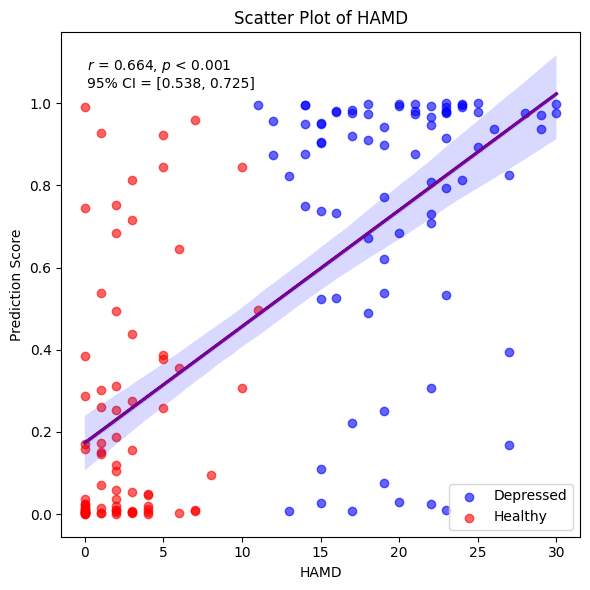

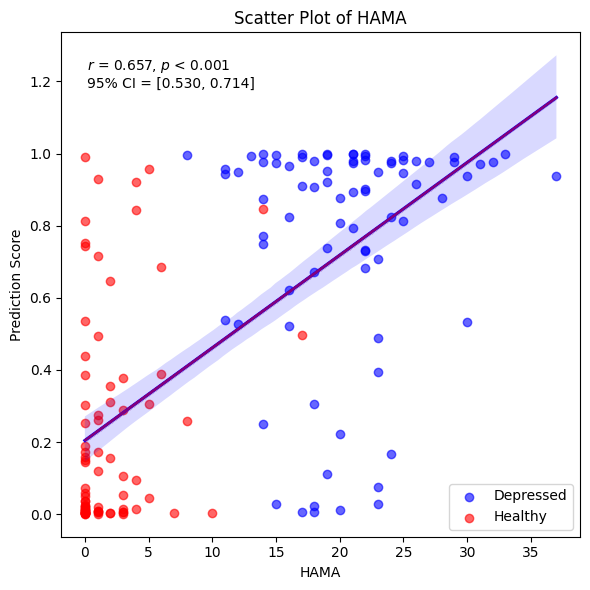

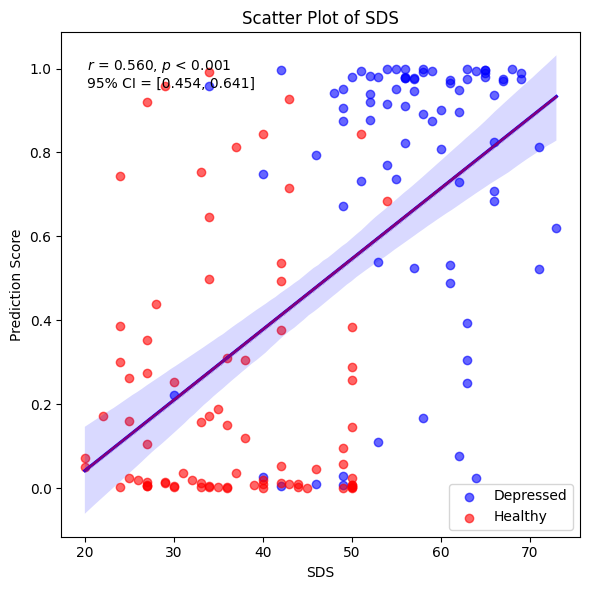

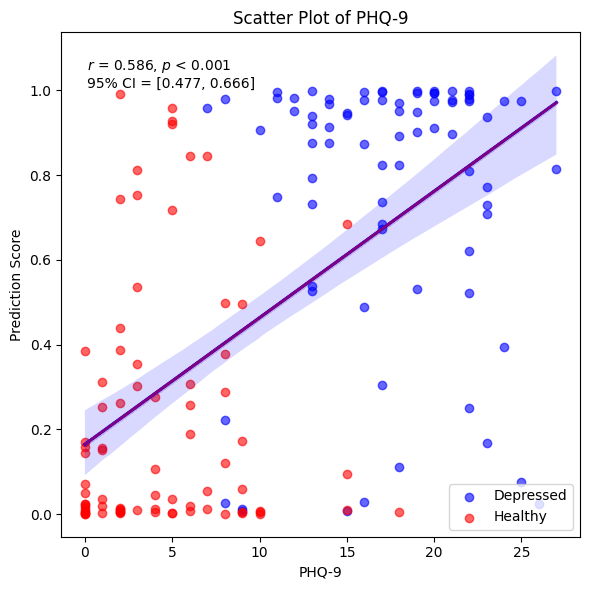

In [11]:
# ============================================
# Depression Severity Prediction (fig. 5)
# ============================================

def plot_and_analyze(df, x_var, y_var='whisper_all_score'):
    df_depressed = df[df['group'] == 'depressed']
    df_healthy = df[df['group'] == 'healthy']

    plt.figure(figsize=(6, 6))
    plt.scatter(df_depressed[x_var], df_depressed[y_var], color='blue', label='Depressed', alpha=0.6)
    plt.scatter(df_healthy[x_var], df_healthy[y_var], color='red', label='Healthy', alpha=0.6)

    r_value, p_value = spearmanr(df[x_var], df[y_var])
    
    n_iterations = 1000
    r_values = []

    for _ in range(n_iterations):
        sample = resample(df[[x_var, y_var]])
        if len(sample[x_var].unique()) > 1 and len(sample[y_var].unique()) > 1:
            r, _ = spearmanr(sample[x_var], sample[y_var])
            r_values.append(r)

    r_values = np.array(r_values)
    ci_lower = np.percentile(r_values, 2.5)
    ci_upper = np.percentile(r_values, 97.5)

    slope, intercept, r_value_lin, p_value_lin, stderr = linregress(df[x_var], df[y_var])
    line = slope * df[x_var] + intercept

    sns.regplot(x=x_var, y=y_var, data=df, scatter=False, color='blue')
    plt.plot(df[x_var], line, color='purple')
    plt.fill_between(df[x_var], line - stderr, line + stderr, color='purple', alpha=0.2)

    p_value_str = f'$p$ = {p_value_lin:.3f}' if p_value_lin >= 0.001 else '$p$ < 0.001'
    text_str = f'$r$ = {r_value_lin:.3f}, {p_value_str}\n95% CI = [{ci_lower:.3f}, {ci_upper:.3f}]'
    plt.text(0.05, 0.95, text_str, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

    plt.xlabel(x_var.replace('17', '').replace('PHQ', 'PHQ-9'))  
    plt.ylabel("Prediction Score")
    plt.legend(loc='lower right')

    plt.title(f'Scatter Plot of {x_var.replace("17", "").replace("PHQ", "PHQ-9")}')
    plt.tight_layout()
    plt.show()

for scale in ['HAMD17', 'HAMA', 'SDS', 'PHQ']:
    plot_and_analyze(external_val_df, scale)

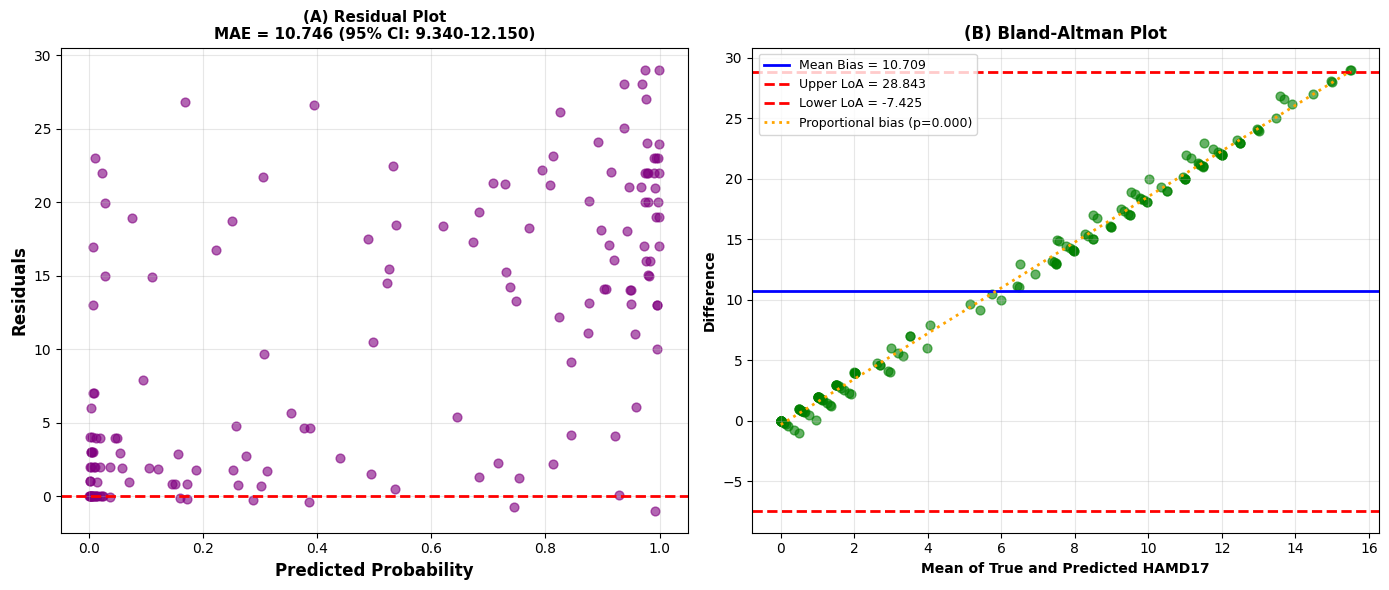

   • Pearson: 0.6642 (95% CI: 0.5602-0.7573)
   • Spearman: 0.6500 (p = 1.4020e-20)
   • MAE : 10.7458 (95% CI: 9.3404-12.1505)
   • RMSE : 14.1335

📊 Bland-Altman Analysis:
   • bias: 10.7093
   • 95% LoA: [-7.4249, 28.8434]
   • proportional_bias: yes (p = 0.0000)


In [12]:
# ============================================
# MAE & Bland-Altman Analysis
# ============================================

y_true_hamd = external_val_df['HAMD17']
y_pred_prob = external_val_df['whisper_all_score']
y_true_hamd = np.asarray(y_true_hamd).astype(float)
y_pred_prob = np.asarray(y_pred_prob).astype(float)

def comprehensive_severity_regression_analysis(y_true_hamd, y_pred_prob, scale_name="HAMD17", save_prefix="HAMD17"):

    n = len(y_true_hamd)
    mae = mean_absolute_error(y_true_hamd, y_pred_prob)
    rmse = np.sqrt(mean_squared_error(y_true_hamd, y_pred_prob))
    medae = np.median(np.abs(y_pred_prob - y_true_hamd))
    r2 = r2_score(y_true_hamd, y_pred_prob)
    pearson_r, pearson_p = stats.pearsonr(y_true_hamd, y_pred_prob)
    spearman_r, spearman_p = stats.spearmanr(y_true_hamd, y_pred_prob)
    
    # 95%CI（Bootstrap）
    np.random.seed(42)
    boot_correlations = []
    boot_maes = []
    for _ in range(2000):
        idx = np.random.choice(n, n, replace=True)
        boot_r, _ = stats.pearsonr(y_true_hamd[idx], y_pred_prob[idx])
        boot_mae = mean_absolute_error(y_true_hamd[idx], y_pred_prob[idx])
        boot_correlations.append(boot_r)
        boot_maes.append(boot_mae)
    corr_ci = (np.percentile(boot_correlations, 2.5), np.percentile(boot_correlations, 97.5))    
    mae_ci = (np.percentile(boot_maes, 2.5), np.percentile(boot_maes, 97.5))

    residuals = y_true_hamd - y_pred_prob 
    mean_values = (y_true_hamd + y_pred_prob) / 2
    differences = y_true_hamd - y_pred_prob
    bias = np.mean(differences)
    std_diff = np.std(differences, ddof=1)
    loa_upper = bias + 1.96 * std_diff
    loa_lower = bias - 1.96 * std_diff
    slope, intercept, r_val, p_val, se = stats.linregress(mean_values, differences)
    proportional_bias = p_val < 0.05



    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14, 6))

    ax1.scatter(y_pred_prob, residuals, alpha=0.6, s=40, color='purple')
    ax1.axhline(y=0, color='red', linestyle='--', linewidth=2)
    ax1.set_xlabel('Predicted Probability', fontweight='bold', fontsize=12)
    ax1.set_ylabel(f'Residuals', fontweight='bold', fontsize=12)
    ax1.set_title(f'(A) Residual Plot\n' + 
                  f'MAE = {mae:.3f} (95% CI: {mae_ci[0]:.3f}-{mae_ci[1]:.3f})', 
                  fontweight='bold', fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    ax2.scatter(mean_values, differences, alpha=0.6, s=40, color='green')
    ax2.axhline(y=bias, color='blue', linestyle='-', linewidth=2, 
                label=f'Mean Bias = {bias:.3f}')
    ax2.axhline(y=loa_upper, color='red', linestyle='--', linewidth=2, 
                label=f'Upper LoA = {loa_upper:.3f}')
    ax2.axhline(y=loa_lower, color='red', linestyle='--', linewidth=2, 
                label=f'Lower LoA = {loa_lower:.3f}')
    if proportional_bias:
        x_range = np.linspace(mean_values.min(), mean_values.max(), 100)
        ax2.plot(x_range, intercept + slope * x_range, 'orange', linestyle=':', 
                linewidth=2, label=f'Proportional bias (p={p_val:.3f})')   
    ax2.set_xlabel(f'Mean of True and Predicted {scale_name}', fontweight='bold')
    ax2.set_ylabel('Difference', fontweight='bold')
    ax2.set_title('(B) Bland-Altman Plot', fontweight='bold')
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)  
    
    plt.tight_layout()
    plt.show()
    
    print(f"   • Pearson: {pearson_r:.4f} (95% CI: {corr_ci[0]:.4f}-{corr_ci[1]:.4f})")
    print(f"   • Spearman: {spearman_r:.4f} (p = {spearman_p:.4e})")
    print(f"   • MAE : {mae:.4f} (95% CI: {mae_ci[0]:.4f}-{mae_ci[1]:.4f})")
    print(f"   • RMSE : {rmse:.4f}")
    
    print(f"\n📊 Bland-Altman Analysis:")
    print(f"   • bias: {bias:.4f}")
    print(f"   • 95% LoA: [{loa_lower:.4f}, {loa_upper:.4f}]")
    print(f"   • proportional_bias: {'yes' if proportional_bias else 'no'} (p = {p_val:.4f})")
    
    return {
        'pearson_r': pearson_r, 'pearson_p': pearson_p, 'corr_ci': corr_ci,
        'spearman_r': spearman_r, 'spearman_p': spearman_p,
        'mae': mae, 'mae_ci': mae_ci, 'rmse': rmse,
        'bias': bias, 'loa_upper': loa_upper, 'loa_lower': loa_lower,
        'proportional_bias': proportional_bias, 'proportional_bias_p': p_val
    }


results = comprehensive_severity_regression_analysis(
     y_true_hamd, y_pred_prob, 
     scale_name="HAMD17",  save_prefix="HAMD17" )
